In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
# import scipy.spatial
import pandas as pd
import sys
# import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing

# %matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
# style.use('seaborn-whitegrid')
sys.path.insert(0, '../') 
print(sys.path)
from ads.utils.readProfiles import *
from ads.utils.global_variables import ABRVS
from ads.utils.general import saveAsNewSheetToExistingFile, write_dataframe_to_excel
from ads.models.Classifier import *
from ads.scripts.classify_moa import get_moa_filename


['../', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '/sise/home/alonshp/AnomalyDetectionScreening/2.MoA_prediction', '/home/alonshp/AnomalyDetectionScreening/ads', '/home/alonshp/.conda/envs/pytorch_ads/lib/python310.zip', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/lib-dynload', '', '/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages']


/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/sise/home/alonshp/AnomalyDetectionScreening


## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - RGCCA

### Paths

In [3]:
import os
from ads.utils.general import set_configs_jupyter, set_paths

# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
exp_name = 'interpretation_try'

configs = set_configs_jupyter(exp_name)

configs.general.debug_mode = True
configs.general.run_all_datasets = False
configs.data.run_data_process = False
configs.model.tune_hyperparams = False
configs.data.feature_select = True
configs.model.deep_decoder = False
configs.model.encoder_type = 'deep'
# configs.data.overwrite_data_creation = True
# dataset : CDRP, CDRP-bio, LINCS, LUAD, TAORF
configs.general.flow = 'run_ad'
# configs.general.flow = 'calc_metrics'
configs.general.dataset = 'LINCS'
configs.general.dataset = 'CDRP-bio'
configs.data.corr_threshold = 0.9
# configs.general.dataset = 'LUAD'
# configs.general.dataset = 'TAORF'

configs.data.modality = 'CellPainting'
# configs.data.modality = 'L1000'

# configs.data.norm_method = 'mad_robustize'
configs.data.profile_type = 'normalized_variable_selected'
configs.data.profile_type = 'augmented'

configs = set_paths(configs)

# configs.moa.moa_dirname = 'MoAprediction_single'

Global seed set to 42


In [4]:

from ads.utils.data_utils import load_data, pre_process,to_dataloaders

data , __ = load_data(configs.general.base_dir,configs.general.dataset,configs.data.profile_type, modality=configs.data.modality)
data,features =  pre_process(data,configs,overwrite = False)
dataloaders = to_dataloaders(data,configs.model.batch_size,features)



 loading /sise/assafzar-group/assafzar/genesAndMorph/preprocessed_data/CDRPBIO-BBBC036-Bray/CellPainting/replicate_level_cp_augmented.csv.gz


/home/alonshp/AnomalyDetectionScreening/ads/utils/readProfiles.py:120: DtypeWarning: Columns (981,982,983) have mixed types. Specify dtype option on import or set low_memory=False.
  l1k_data_repLevel=pd.read_csv(dataDir+'/L1000/replicate_level_l1k.csv.gz')


ATTENTION: l1k_data_repLevel IS standardized per plate EVEN with flag "per_plate_normalized_flag"=False
        To change this, move the standartization into the flag condition in "read_replicate_level_profiles function"
List loaded from /sise/assafzar-group/assafzar/genesAndMorph/anomaly_output/CDRP-bio/CellPainting/augmented_0.9_features.txt successfully.
loading normalized data from file...


In [5]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa682bf8ac0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fa682bfbf70>,
 'test_ctrl': <torch.utils.data.dataloader.DataLoader at 0x7fa682bf9120>,
 'test_treat': <torch.utils.data.dataloader.DataLoader at 0x7fa682bfbca0>}

/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alonshp/.conda/envs/pytorch_ads/lib/python3.10 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alonshp/.conda/envs/pytorch_ads/lib/python3.10 ...
  rank_zero_warn(
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-pa

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 365: 100%|██████████| 45/45 [00:00<00:00, 235.56it/s, v_num=1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/alonshp/.conda/envs/pytorch_ads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 348.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mse            │     0.296366423368454     │
│            pcc            │    0.8408562541007996     │
│            r2             │    0.7071142196655273     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 370.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mse            │    0.5032445192337036     │
│            pcc            │    0.8134634494781494     │
│            r2             │     0.662346363067627     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 56/56 [00:00<00:00, 352.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mse            │    0.4485774338245392     │
│            pcc            │    0.8219948410987854     │
│            r2             │    0.6766847968101501     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 550/550 [00:01<00:00, 511.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mse            │     8.095744132995605     │
│            pcc            │    0.7283652424812317     │
│            r2             │    0.5381577610969543     │
└───────────────────────────┴───────────────────────────┘

saved diff files
       val_loss  val_l2_loss  train_loss  train_l2_loss  mse  pcc  r2
epoch                                                                
0      0.933733     0.004162         NaN            NaN  NaN  NaN NaN
1           NaN          NaN    0.888037       0.003144  NaN  NaN NaN
1      0.808399     0.004743         NaN            NaN  NaN  NaN NaN
2           NaN          NaN    0.446194       0.004040  NaN  NaN NaN
2      0.764075     0.004976         NaN            NaN  NaN  NaN NaN


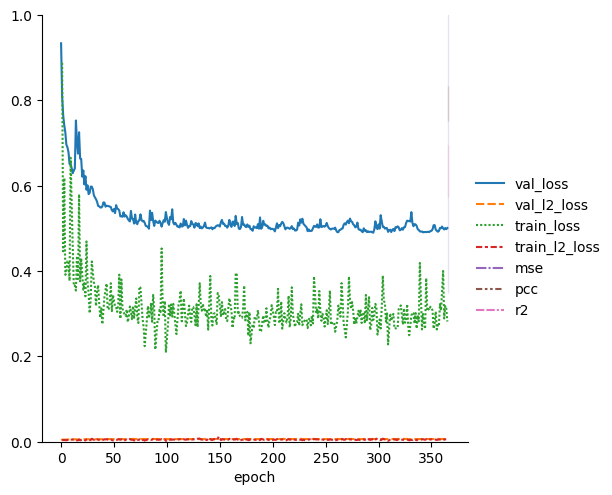

In [6]:
from ads.scripts.run_ad import train_autoencoder, test_autoencoder, save_treatments

model,losses = train_autoencoder(dataloaders, features, configs) 

In [9]:
preds['test_ctrl']

KeyError: 'test_ctrl'

In [10]:
test_dataloaders = list(dataloaders.keys())[2:]
preds, z_preds = test_autoencoder(model, dataloaders, features, configs)

preds_normalized=save_treatments(data, preds['test_ctrl'],preds['test_treat'], configs.general.output_exp_dir,  f'replicate_level_{configs.data.modality_str}_{configs.data.profile_type}_ae', configs, features)
# save_treatments(data, z_pred_ctrl,z_pred_treat, configs.general.output_exp_dir,  f'replicate_level_{configs.data.modality_str}_{configs.data.profile_type}_ae_embeddings', configs, features, embeddings=True)
diffs_normalized= save_treatments(data, preds['test_ctrl'] - data[data['Metadata_set'] == 'test_ctrl'][features],preds['test_treat'] - data[data['Metadata_set'] == 'test_treat'][features], configs.general.output_exp_dir,  f'replicate_level_{configs.data.modality_str}_{configs.data.profile_type}_ae_diff', configs, features)


ratio of null values after normalization: 0.0
ratio of null values after normalization: 0.0


## Calc mAP score

In [ ]:
def get_metacols(df):
    """return a list of metadata columns"""
    return [c for c in df.columns if c.startswith("Metadata_")]


def get_featurecols(df):
    """returna  list of featuredata columns"""
    return [c for c in df.columns if not c.startswith("Metadata")]


def get_metadata(df):
    """return dataframe of just metadata columns"""
    return df[get_metacols(df)]


def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]

def CalculatePercentReplicating(dfs, group_by_feature, n_replicates, n_samples=10000,
                                description='Unknown', percent_matching=False):
    """

    :param dfs: list of plate dataframes that are analysed together.
    :param group_by_feature: feature column which is used to make replicates
    :param n_replicates: number of expected replicates present in the given dataframes 'dfs' based on the 'group_by_feature' column
    :param n_samples: number of samples used to calculate the null distribution, often 10000
    :return: dataframe consisting of the calculated metrics
    """
    # Set plotting and sampling parameters
    random.seed(9000)
    plt.style.use("seaborn-ticks")
    plt.rcParams["image.cmap"] = "Set1"
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

    corr_replicating_df = pd.DataFrame()

    # Merge dfs in list
    try:
        data_df = pd.concat(dfs)
    except:
        data_df = dfs
    print('Created df of size: ', data_df.shape)
    metadata_df = utils_benchmark.get_metadata(data_df)
    features_df = utils_benchmark.get_featuredata(data_df).replace(np.inf, np.nan).dropna(axis=1, how="any")

    data_df = pd.concat([metadata_df, features_df], axis=1)

    replicating_corr = list(utils_benchmark.corr_between_replicates(data_df, group_by_feature, percent_matching))  # signal distribution
    null_replicating = list(utils_benchmark.corr_between_non_replicates(data_df, n_samples=n_samples, n_replicates=n_replicates,
                                                              metadata_compound_name=group_by_feature))  # null distribution

    prop_95_replicating, value_95_replicating = utils_benchmark.percent_score(null_replicating,
                                                                    replicating_corr,
                                                                    how='right')


    corr_replicating_df = corr_replicating_df.append({'Description': f'{description}',
                                                      'Replicating': replicating_corr,
                                                      'Null_Replicating': null_replicating,
                                                      'Percent_Replicating': '%.1f' % prop_95_replicating,
                                                      'Value_95': value_95_replicating}, ignore_index=True)

    return corr_replicating_df




def CalculateMAP(df, distance='euclidean', groupby='Metadata_MoA', percent_matching=False):
    df = df.sort_values(by=groupby)

    if percent_matching:
        df.dropna(subset=[groupby], inplace=True)
        df.reset_index(drop=True, inplace=True)

    features = utils_benchmark.get_featuredata(df)

    if distance == 'cosine_similarity':
        dist = pd.DataFrame(cosine_similarity(features))
    elif distance == 'euclidean':
        dist = pd.DataFrame(euclidean_distances(features))

    compound_names = pd.Series(list(df[groupby]))
    dist.set_axis(compound_names, axis=1, inplace=True)
    dist.set_axis(compound_names, axis=0, inplace=True)

    np.fill_diagonal(dist.values, -1)
    well_APs = []
    PatRs = []

    if percent_matching:
        df.reset_index(drop=True, inplace=True)

    iterator = dist.iterrows()
    for index, row in iterator:
        if percent_matching:
            row.reset_index(drop=True, inplace=True)
            current_compound = df['Metadata_pert_iname'][row == -1].values[0]
            indices1 = set(df['Metadata_pert_iname'][df['Metadata_pert_iname']==current_compound].index)
            indices2 = set(df['Metadata_pert_iname'][df[groupby] == index].index)
            sister_indices = indices2 - indices1
            if len(sister_indices) == 0:
                compound_names = compound_names.drop(list(indices1))
                next(islice(iterator, len(indices1)-2, None), '')
                continue
            row.drop(list(indices1), inplace=True)
            labels = copy.deepcopy(row)
            labels.values[:] = 0
            labels.loc[list(sister_indices)] = 1  # set other compound but with same index to 1 only

            row.reset_index(drop=True, inplace=True)
            labels.reset_index(drop=True, inplace=True)
        else:
            row = row[row != -1]
            labels = copy.deepcopy(row)
            labels.values[:] = 0
            labels[index] = 1

        # Calculate AP
        AP = average_precision_score(labels, row)
        AP_corrected = AP - (sum(labels)/len(labels))  # correct AP by subtracting the random baseline
        if AP_corrected < 0:
            AP_corrected = 0
        well_APs.append(AP_corrected)
        # Calculate P@R
        PatR = precision_at_k(labels, row, k=int(sum(labels)))
        PatRs.append(PatR)

    scores = pd.DataFrame(zip(compound_names, well_APs, PatRs), columns=['compound', 'AP', 'precision at R'])

    # plt.figure(figsize=(14, 10), dpi=300)
    # # plot the heatmap
    # sns.heatmap(dist, xticklabels=compound_names, yticklabels=compound_names, annot=True)
    # plt.title('Cosine Similarity compounds')
    # plt.show()
    return scores


def precision_at_k(y_true, y_score, k, pos_label=1):


    y_true_type = type_of_target(y_true)
    if not (y_true_type == "binary"):
        raise ValueError("y_true must be a binary column.")

    # Makes this compatible with various array types
    y_true_arr = column_or_1d(y_true)
    y_score_arr = column_or_1d(y_score)

    y_true_arr = y_true_arr == pos_label

    desc_sort_order = np.argsort(y_score_arr)[::-1]
    y_true_sorted = y_true_arr[desc_sort_order]
    y_score_sorted = y_score_arr[desc_sort_order]

    true_positives = y_true_sorted[:k].sum()

    return true_positives / k


In [ ]:
for m in methods:
    # Calculate mAP
    MLP_profiles = methods[m]['zscores']
    MLP_profiles.columns = [methods[m]['features'] + ['Metadata_MoA']
    MLP_profiles = MLP_profiles[MLP_profiles.Metadata_MoA.duplicated(keep=False)]  # filter out non-replicates

    AP = utils.CalculateMAP(MLP_profiles, 'cosine_similarity',
                            groupby='Metadata_MoA', percent_matching=False)
    # assign the mAP (no running variable because this is calculated over the entire dataset)
    val_mAP = AP.A

'augmented_n9_f10_a_d_ba_cal'

In [ ]:

if debug:
    saved_scores_cdrpbio = res
else:
    filename=os.path.join(save_dir,'pred_moa_res_all.xlsx')
    saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
sgkf_keys_all = saved_scores_cdrpbio.keys()



In [ ]:
saved_scores_cdrpbio.keys()
# saved_scores_cdrpbio[sgkf_keys[0]]
# sgkf_keys
# methods.keys()
sgkf_keys = []
if tune:
    sgkf_keys = [s for s in sgkf_keys_all if '-t'  in s]
    if tune_all_folds:
        sgkf_keys = [s for s in sgkf_keys_all if '-ta'  in s]
    else:
        sgkf_keys = [s for s in sgkf_keys_all if not '-ta'  in s]
else:
    sgkf_keys = [s for s in sgkf_keys_all if not '-t'  in s]
sgkf_keys

['anomaly_diff-lr-t',
 'anomaly_diff-mlp-t',
 'raw_a-lr-t',
 'raw_a-mlp-t',
 'fuse-lr-t',
 'fuse-mlp-t']

In [ ]:
for key in saved_scores_cdrpbio.keys():
    print('num values for {key} is {num}'.format(key=key,num=saved_scores_cdrpbio[key].shape[0]))
# saved_scores_cdrpbio['raw_a-lr'].shape

num values for anomaly_diff-lr-t is 11920
num values for anomaly_diff-mlp-t is 11920
num values for raw_a-lr-t is 11920
num values for raw_a-mlp-t is 11920
num values for fuse-lr-t is 11920
num values for fuse-mlp-t is 11920
num values for anomaly_diff-lr-ta is 11920
num values for anomaly_diff-mlp-ta is 11920
num values for raw_a-lr-ta is 11920
num values for raw_a-mlp-ta is 11920
num values for fuse-lr-ta is 11920
num values for fuse-mlp-ta is 11920


In [ ]:
from sklearn.metrics import f1_score
#########################################################
res_df =pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
res_df_exp_level = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','Fold','exp_num'])

# DS='CDRP-bio'
# scores_mlp=saved_scores_cdrpbio[DS+'-nvs-mlp-ht-sgkf-10f']
# scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
reps = ['CellProfiler', 'Anomaly', 'Fusion']
methods = ['lr', 'mlp']

# res_df = pd.DataFrame(columns=['Modality','Model','Type','F1-macro','F1-weighted','exp_num','Fold'])
for i ,k in enumerate(sgkf_keys):
    # data_representation = k.split('-')[0]
    # m = methods[i]
    if 'anomaly' in k:
        data_representation = reps[1]
    elif 'raw' in k: 
        data_representation = reps[0]
    else:
        data_representation= reps[2]

    if 'mlp' in k:
        model = 'MLP'
    elif 'lr' in k: 
        model = 'Logistic R'
    elif 'xgboost' in k:
        model = 'XGBoost'
    print(model)
    print(data_representation)
    res_df_method, res_df_exp_level_method = concat_model_scores(saved_scores_cdrpbio[k], model,data_type = data_representation) 
    res_df = pd.concat([res_df,res_df_method])
    res_df_exp_level = pd.concat([res_df_exp_level,res_df_exp_level_method])
    
n_classes = saved_scores_cdrpbio[k].Metadata_moa_num.nunique()


Logistic R
Anomaly


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

MLP
Anomaly


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

Logistic R
CellProfiler


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

MLP
CellProfiler


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

Logistic R
Fusion


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

MLP
Fusion


/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'CP':'CellPainting','Late Fusion':'CellPainting+L1000'},inplace=True)
/tmp/ipykernel_37685/1422545948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename

In [ ]:
# saved_scores_cdrpbio[k].Metadata_moa_num.nunique()
saved_scores_cdrpbio.keys()

dict_keys(['anomaly_diff-lr-t', 'anomaly_diff-mlp-t', 'raw_a-lr-t', 'raw_a-mlp-t', 'fuse-lr-t', 'fuse-mlp-t', 'anomaly_diff-lr-ta', 'anomaly_diff-mlp-ta', 'raw_a-lr-ta', 'raw_a-mlp-ta', 'fuse-lr-ta', 'fuse-mlp-ta'])

In [ ]:
# res_df_cdrpbio
# style.use('seaborn-colorblind')
# style.use('tableau-colorblind10')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":16,"axes.labelsize":16})
pallete= "Set2"
sns.color_palette(pallete)
sns.set(style="whitegrid", palette=pallete)

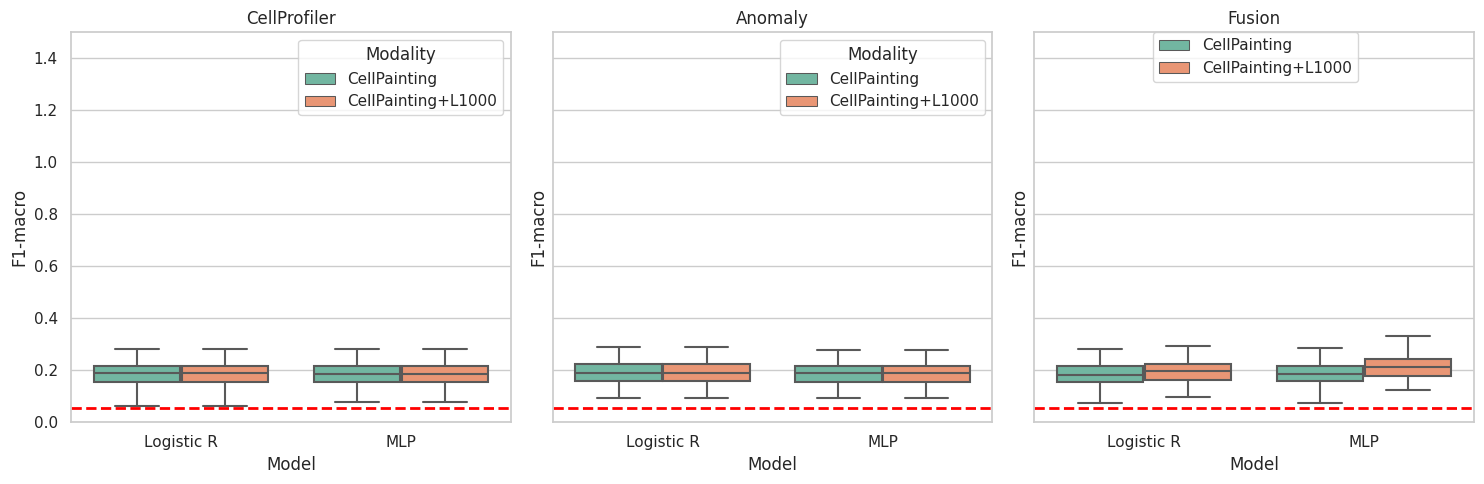

In [ ]:

# colors = ["tab:green","tab:orange","tab:blue"]
# sns.set_style("whitegrid")
n_cols = len(reps)
fig,axes=plt.subplots(1,n_cols,figsize=(5*n_cols,5),sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(reps):
    # p_abrv = p.split('_')[0]
    # print(p_abrv)
    sns.boxplot(x="Model", y="F1-macro", hue="Modality", data=res_df[res_df["Type"]==p],ax=axes[i])#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)
    # sns.set_palette(pallete)
    
    axes[i].set_ylim(0,1.5)
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()

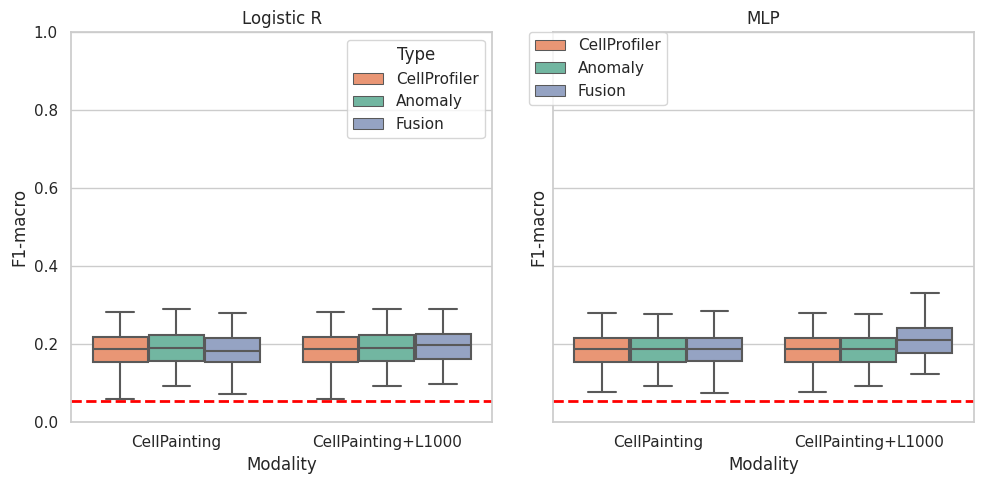

In [ ]:
# res_df_cdrpbio
import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# pallete2 = sns.color_palette("Set2")
# pallete2
pallete3 = [sns.color_palette("Set2")[1],sns.color_palette("Set2")[0],sns.color_palette("Set2")[2]]
# palette
sns.set(style="whitegrid", palette=pallete3)
# sns.set_style("whitegrid")
methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP','XGBoost']
models = ['Logistic R','MLP']
hue_order = ['CellProfiler','Anomaly', 'Fusion']

Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    sns.boxplot(x="Modality", y="F1-macro", hue="Type", data=res_df[res_df["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,1)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
plt.legend(bbox_to_anchor=(0.27, 1), loc='upper right', borderaxespad=0)
# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'moa_all_modalities_bar_{moa_csv_filename}.png')
plt.savefig(save_path,dpi=500)

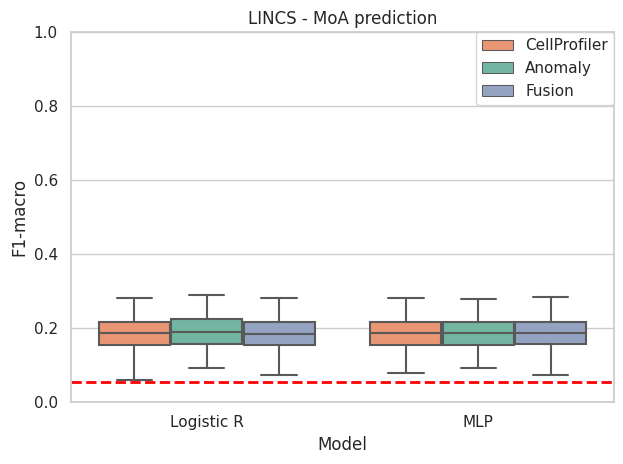

In [ ]:

methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP']
# Modalities = ['CellPainting', 'L1000', 'CP+L1000']

g = sns.boxplot(x="Model", y="F1-macro", hue="Type", data=res_df[res_df["Modality"]==modality],hue_order=hue_order)#,**kwargs)
    # plt.legend(loc='top', borderaxespad=0)

g.set_ylim(0,1)
# axes[0].set_title('CDRP-bio')
g.set_title(f'{dataset} - MoA prediction')
# n_classes=16;
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend(bbox_to_anchor=(0.27, 1), loc='upper right', borderaxespad=0)
g.legend( loc='upper right', borderaxespad=0)

# axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'moa_bar_{moa_csv_filename}.png')
plt.savefig(save_path,dpi=500)

In [ ]:
res_df_grouped_folds = res_df.groupby(['Model','Modality','Type','exp_num']).mean().reset_index()

# sns.set_style("whitegrid")
# fig,axes=plt.subplots(1,1,figsize=(5,5),sharey=True)
methods = ['AnomalyCP','CP']
models = ['Logistic R','MLP']
# Modalities = ['CP', 'GE', 'Early Fusion']
modality = 'CellPainting'

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# for i,p in enumerate(models):


In [ ]:
res_df_grouped_folds.sort_values(by='F1-weighted',ascending=True,inplace=True)

In [ ]:
res_df_grouped_folds = res_df_grouped_folds[res_df_grouped_folds['Modality']!='L1000']

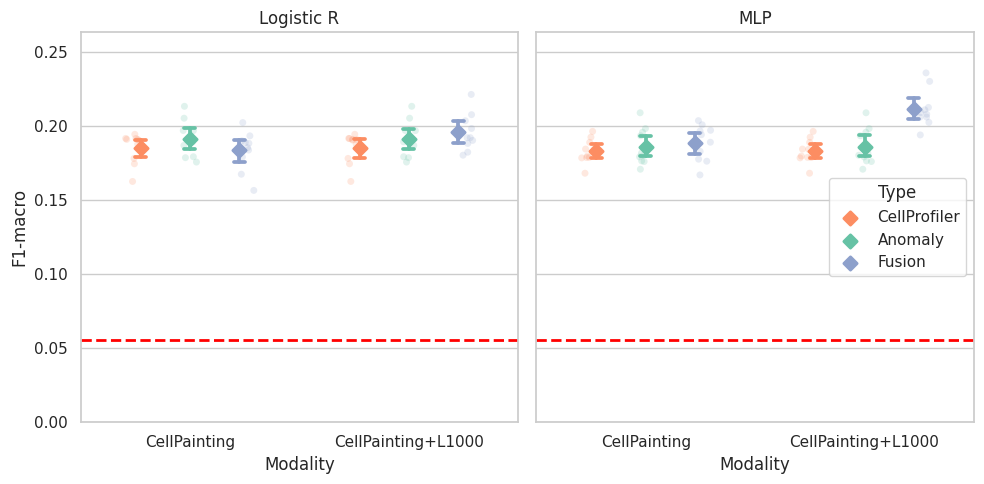

In [ ]:
# res_df_cdrpbio
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set(style="whitegrid", palette=pallete)
# sns.set_style("whitegrid")
from utils.global_variables import methods_colors_list_for_moa
# methods = ['AnomalyCP','CP']
# models = ['Logistic R','MLP']
metric = 'F1-macro'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    order = ['CellPainting', 'CellPainting+L1000']
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    order = ['CellPainting', 'CellPainting+L1000']
    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_filename}_{metric}.png')
plt.savefig(save_path,dpi=500)

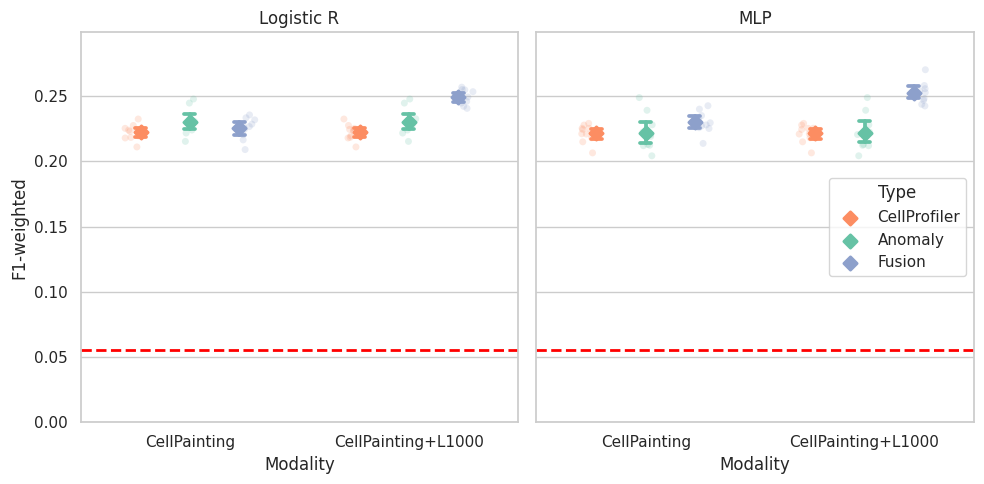

In [ ]:
# res_df_cdrpbio
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set(style="whitegrid", palette=pallete)
# sns.set_style("whitegrid")
from utils.global_variables import methods_colors_list_for_moa
# methods = ['AnomalyCP','CP']
# models = ['Logistic R','MLP']
metric = 'F1-weighted'
# Modalities = ['CP', 'GE', 'Early Fusion', 'Late Fusion','Late Fusion']
nCols = len(models)
fig,axes=plt.subplots(1,nCols,figsize=(5*nCols,5),sharey=True)
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
for i,p in enumerate(models):
    # sns.boxplot(x="Modality", y=metric, hue="Type", data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p],ax=axes[i],hue_order=hue_order)#,**kwargs)

    sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, 
    order = ['CellPainting', 'CellPainting+L1000']
)

    sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Model"]==p], x="Modality", y=metric, hue="Type",ax=axes[i],
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, 
    order = ['CellPainting', 'CellPainting+L1000']
    # markerssize=20, markersedgewidth=3,
)
    # plt.legend(loc='top', borderaxespad=0)

    axes[i].set_ylim(0,max_val+0.05)
    # axes[i].set_xticks()
    # axes[0].set_title('CDRP-bio')
    axes[i].set_title(p)
    # n_classes=16;
    axes[i].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='lower right', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
save_path = os.path.join(fig_dir,f'stripplot_all_modalities_bar_{moa_csv_filename}_{metric}.png')
plt.savefig(save_path,dpi=500)

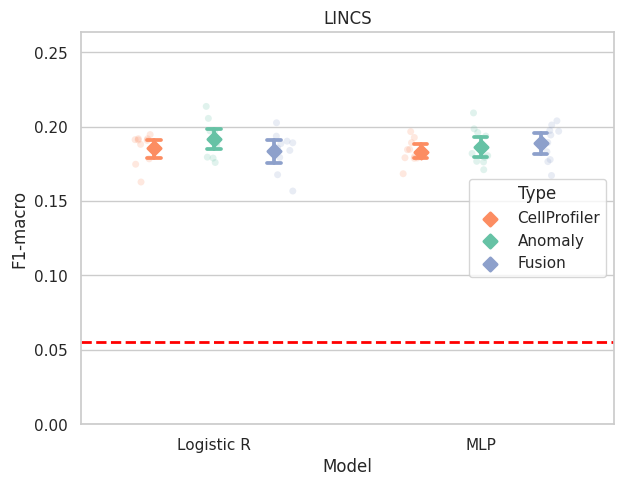

In [ ]:
# res_df_grouped_folds.groupby(['Model','Modality','Type'])['F1-macro'].describe()
# res_df_grouped_folds
metric = 'F1-macro'
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, order = ['Logistic R','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D", hue_order=hue_order, order = ['Logistic R','MLP']
    # markerssize=20, markersedgewidth=3,
)
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
# g.legend( loc='lower right', borderaxespad=0)
# g.legend(loc='upper right', bbox_to_anchor=(0.6, 0.1))
# g.legend(loc='upper right')

# g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)

g.set_ylim(0,max_val+0.05)
plt.tight_layout()
plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_filename}.png')
plt.savefig(save_path,dpi=500)

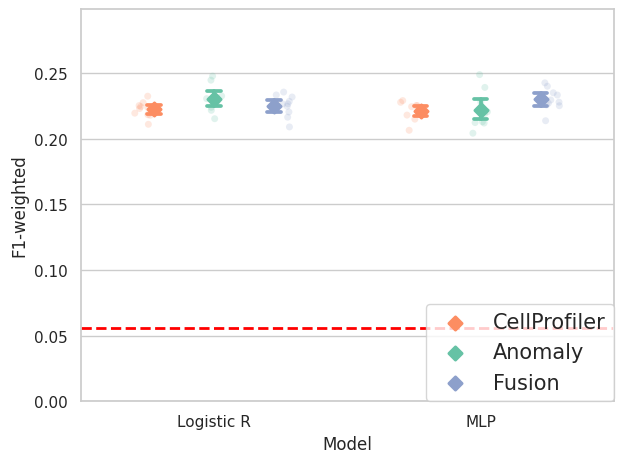

In [ ]:
# sns.set_context("paper",font_scale = 1.8, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})

metric = 'F1-weighted'
max_val = res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order, order = ['Logistic R','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds[res_df_grouped_folds["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=hue_order, order = ['Logistic R','MLP']
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0,max_val+0.05)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)

plt.tight_layout()
# plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_filename}.png')
plt.savefig(save_path,dpi=500)

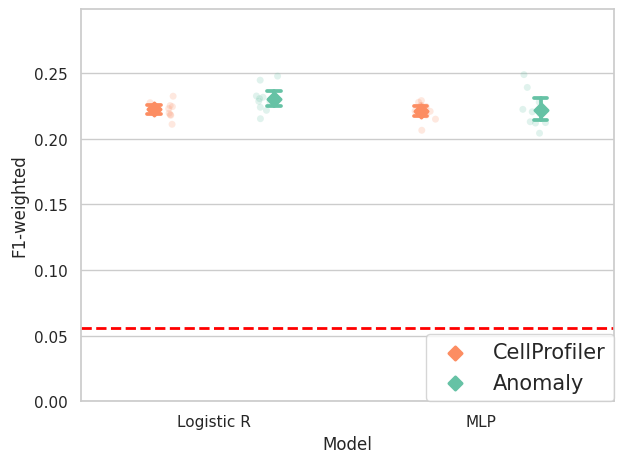

In [ ]:
########### w/o Fusion #############
metric = 'F1-weighted'

res_df_grouped_folds_no_fusion = res_df_grouped_folds[res_df_grouped_folds['Type']!='Fusion']

max_val = res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=['CellProfiler', 'Anomaly'], order = ['Logistic R','MLP']
)
g =sns.pointplot(
    data=res_df_grouped_folds_no_fusion[res_df_grouped_folds_no_fusion["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=['CellProfiler', 'Anomaly'], order = ['Logistic R','MLP']
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.set_ylim(0,max_val+0.05)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)

plt.tight_layout()
# plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_filename}_no_fusion.png')
plt.savefig(save_path,dpi=500)

Welch's t-test results:
t-statistic: 0.1831693494969977
p-value: 0.8559856540550428


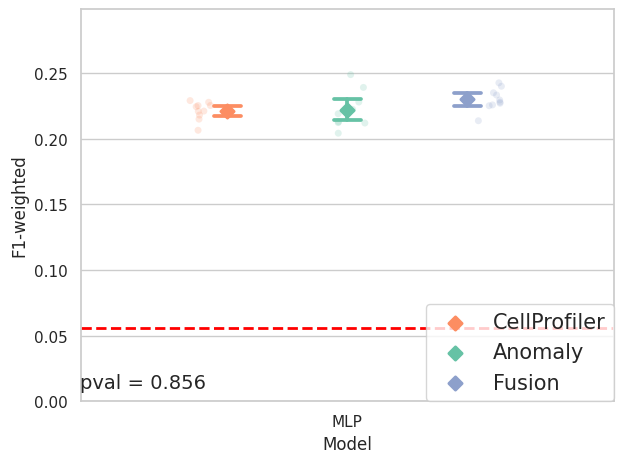

In [ ]:
########### only MLP #############
from scipy.stats import ttest_ind


res_df_grouped_folds_mlp = res_df_grouped_folds[res_df_grouped_folds['Model']=='MLP']

metric = 'F1-weighted'
max_val = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order
)
g =sns.pointplot(
    data=res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=hue_order
    # markerssize=20, markersedgewidth=3,
)

g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)
g.set_ylim(0,max_val+0.05)

# Extract the data for 'CellProfiler' and 'Anomaly'
data_cellprofiler = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'CellProfiler']['F1-weighted']
data_anomaly = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'Anomaly']['F1-weighted']

# Perform Welch's t-test
t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

# Print the results
print("Welch's t-test results:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


plt.tight_layout()
# plt.title(f'{dataset}_pval = {p_value:.3f}')
plt.text(-0.5, 0.01, f'pval = {p_value:.3f}', fontsize=14)
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_filename}_mlp_only.png')
plt.savefig(save_path,dpi=500)


Welch's t-test results:
t-statistic: 3.2724924679189384
p-value: 0.0026031127663795847


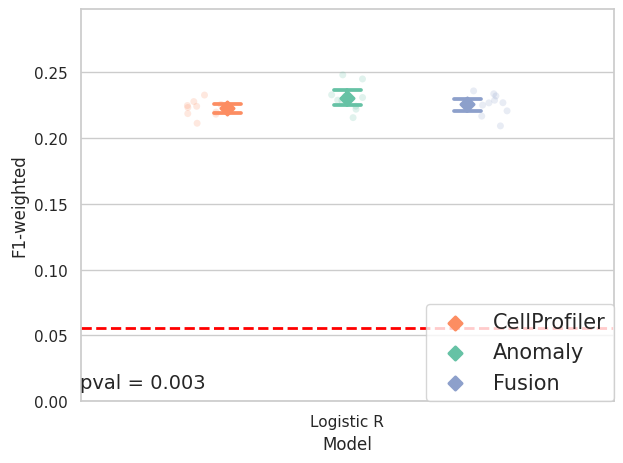

In [ ]:
########### only LR #############

res_df_grouped_folds_mlp = res_df_grouped_folds[res_df_grouped_folds['Model']=='Logistic R']

metric = 'F1-weighted'
max_val = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality].groupby(['Model','Type'])[metric].max().max()

sns.stripplot(
    data=res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=True, alpha=.2, legend=False,hue_order=hue_order
)
g =sns.pointplot(
    data=res_df_grouped_folds_mlp[res_df_grouped_folds_mlp["Modality"]==modality], x="Model", y=metric, hue="Type",
    dodge=.45, 
    linestyles="none", 
    errorbar=("ci", 95), capsize=.05,
    markers="D",hue_order=hue_order
    # markerssize=20, markersedgewidth=3,
)
# g = sns.barplot(
#     data=res_df_grouped_folds[res_df_grouped_folds["Modality"]=='CP'], x="Model", y="F1-weighted", hue="Type",
#     errorbar=("pi", 50), capsize=.1,
#     # err_kws={"color": ".5", "linewidth": 2.5},
#     # linewidth=2.5, edgecolor=".5", facecolor=(0, 0, 0, 0),
# )
g.axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2)
g.legend(loc = 'lower right', borderaxespad=0, fontsize=15)
g.set_ylim(0,max_val+0.05)
plt.tight_layout()

# Extract the data for 'CellProfiler' and 'Anomaly'
data_cellprofiler = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'CellProfiler']['F1-weighted']
data_anomaly = res_df_grouped_folds_mlp[res_df_grouped_folds_mlp['Type'] == 'Anomaly']['F1-weighted']

# Perform Welch's t-test
t_stat, p_value = ttest_ind(data_anomaly,data_cellprofiler, equal_var=False)

# Print the results
print("Welch's t-test results:")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")
plt.text(-0.5, 0.01, f'pval = {p_value:.3f}', fontsize=14)

# plt.title(f'{dataset}_pval = {p_value:.3f}')
# plt.title(f'{dataset}')
save_path = os.path.join(fig_dir,f'moa_multi_{metric}_{moa_csv_filename}_lr_only.png')
plt.savefig(save_path,dpi=500)

['anomaly_diff-mlp-t', 'raw_a-mlp-t', 'fuse-mlp-t']
Index(['Anomaly', 'CellPainting', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')
['anomaly_diff-lr-t', 'raw_a-lr-t', 'fuse-lr-t']
Index(['Anomaly', 'CellPainting', 'Fusion', 'Metadata_moa_num',
       'Metadata_moa_with_n', 'Metadata_MoA'],
      dtype='object')


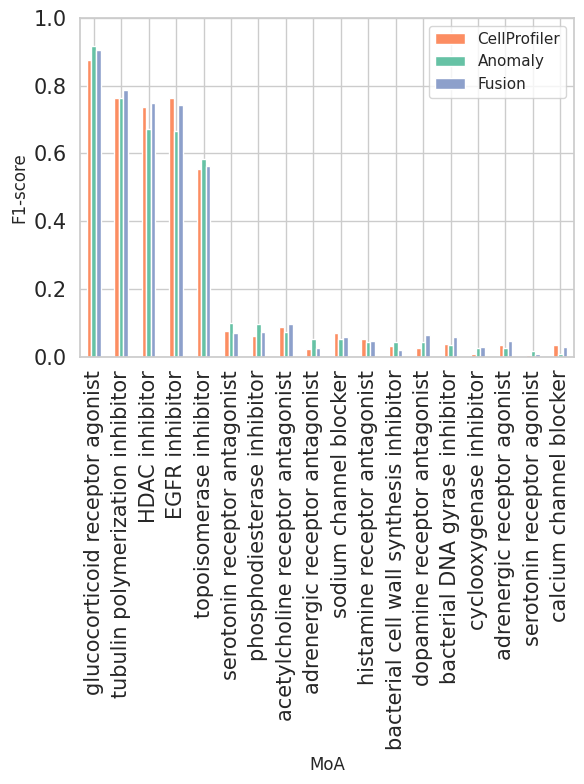

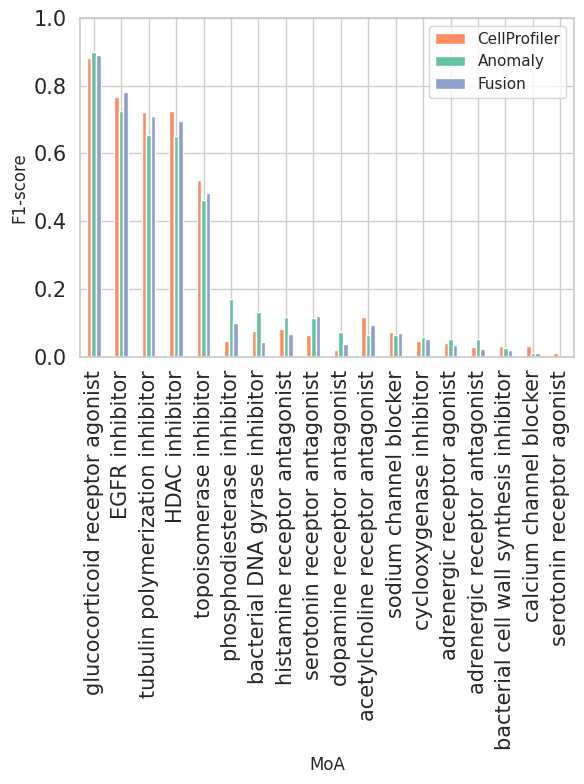

In [ ]:

from sklearn.metrics import classification_report

# for model in ['lr','mlp','xgb']:
for model in ['mlp','lr']:


    # model = 'mlp'
    # # 1. Choose results by model and modality
    model_keys = [k for k in sgkf_keys if model in k]
    print(model_keys)

    scores = {}
    scores_mlp={}
    for k in model_keys:
        # if 'err' in k:
            # rep = 'AE_err'
        if 'anomaly' in k:
            rep = 'Anomaly'
        elif 'raw' in k:
            rep = 'CellPainting'
        elif 'fuse' in k:
            rep = 'Fusion'
        
        scores_model = saved_scores_cdrpbio[k]
        scores[rep] = scores_model['CP']

    for rep in scores.keys():
        scores_mlp[rep]  = scores[rep]
        
    scores_mlp['Metadata_moa_num']=scores_model['Metadata_moa_num']
    scores_mlp['Metadata_moa_with_n']=scores_model['Metadata_moa_with_n']
    # scores_model['Metadata_MoA'] = scores_model['Metadata_moa_with_n']
    scores_mlp['Metadata_MoA']=scores_model['Metadata_moa_with_n'].apply(lambda x: x.split(' (')[0])
    
    scores_mlp = pd.DataFrame(scores_mlp)
    print(scores_mlp.keys())
    # # 2. reformat scores to be able to use classification report


    # scores_mlp = pd.concat(saved_scores_cdrpbio[mlp_keys])
    # scores_mlp=res_df[(res_df["Modality"]=="CP") & (res_df["Model"]=="MLP")]
    # scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

    # scor_vals_ae=scores_mlp['AE_pred'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_raw=scores_mlp['CellPainting'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_ae_err=scores_mlp['Anomaly'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
    scor_vals_fuse=scores_mlp['Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)   
 

    # report_clss_ae_pred=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae.values,output_dict=True)).transpose()
    report_clss_ae_err=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ae_err.values,output_dict=True)).transpose()
    report_clss_raw=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_raw.values,output_dict=True)).transpose()
    report_clss_fuse=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_fuse.values,output_dict=True)).transpose()
    # report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

    
    # report_clss[list(range(13))]
    # n_classes=14
    # n_classes=16

    report_clss_ae_err['MoA']=''
    # report_clss2 
    # report_clss
    # labels = [str(i) for i in range(n_classes)]
    # report_clss_ae_err.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
    # mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
    mapping =list(scores_mlp.groupby(['Metadata_MoA', 'Metadata_moa_num']).groups.keys())
    mapping = {k[1]:k[0] for k in mapping}  
    for row in report_clss_ae_err.index[0:n_classes]:
        report_clss_ae_err.loc[row,'MoA']=mapping[int(row)]
    
    report_clss2=report_clss_ae_err[0:n_classes]
    report_clss2



    # # 3. Plotting

    # report_clss_cp.loc[report_clss3.index]['f1-score']
    %matplotlib inline
    # import matplotlib.style as style
    # style.use('seaborn-colorblind')
    # sns.set_style("whitegrid")
    # sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
    report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
    report_clss3['f1-score-raw']=report_clss_raw.loc[report_clss3.index]['f1-score'].values
    report_clss3['f1-score-fuse']=report_clss_fuse.loc[report_clss3.index]['f1-score'].values
    # report_clss3['f1-score-ae_err']=report_clss_ae_err.loc[report_clss3.index]['f1-score'].values

    # report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
    # report_clss4=report_clss3[['f1-score','f1-score-raw','f1-score-ae_err']]
    report_clss4=report_clss3[['f1-score-raw','f1-score','f1-score-fuse']]

    report_clss4=report_clss4.rename(columns={'f1-score-raw':'CellProfiler','f1-score':'Anomaly','f1-score-fuse':'Fusion'})
    report_clss4.index=report_clss3['MoA']
    # ax = report_clss4.plot.bar(rot=90,figsize=(int(n_classes/3.5),8),fontsize=15,linewidth=1)
    ax = report_clss4.plot.bar(rot=90,figsize=(int(n_classes/3),8),fontsize=15,linewidth=1)

    # ax = report_clss4[report_clss4["AE"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)

    # plt.title(f'{dataset} class specific F1-scores ({model})')
    plt.ylabel('F1-score')
    ax.set_ylim([0,1])
    plt.tight_layout()
    save_path = os.path.join(fig_dir,f'moa_specific_{model}_{moa_csv_filename}.png')
    plt.savefig(save_path,dpi=500)
    # if 1:
    #     source_data_add='../Figs_Source_Data.xlsx'
    #     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    #     # fig.tight_layout()
    #     plt.savefig('fig4c_1.pdf',dpi=500)

In [ ]:
n_classes

18

In [ ]:
metric = 'f1-score'
f1_thresh = 0.1
print(f'f1-score threshold: {f1_thresh}')
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

f1-score threshold: 0.1


(9, 12, 10)

In [ ]:
metric = 'f1-score'
f1_thresh = 0.2
print(f'f1-score threshold: {f1_thresh}')
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

f1-score threshold: 0.2


(8, 8, 8)

In [ ]:
metric = 'f1-score'
f1_thresh = 1/n_classes + 0.05
print(f'f1-score threshold: {f1_thresh}')
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

f1-score threshold: 0.10555555555555556


(9, 12, 9)

In [ ]:
metric = 'f1-score'
f1_thresh = 1/n_classes + 0.1
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

(8, 9, 8)

In [ ]:
metric = 'recall'
f1_thresh = 0.1
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

(11, 12, 10)

In [ ]:
metric = 'recall'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

(8, 8, 8)

In [ ]:
metric = 'precision'
f1_thresh = 0.1
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()


(9, 11, 9)

In [ ]:

metric = 'precision'
f1_thresh = 0.2
(report_clss_raw[metric]>f1_thresh).sum(), (report_clss_ae_err[metric]>f1_thresh).sum(),(report_clss_fuse[metric]>f1_thresh).sum()

(8, 9, 8)

In [ ]:
res_df.head()

,Modality,Model,Type,F1-macro,F1-weighted,exp_num,Fold
0,CellPainting,Logistic R,Anomaly,0.211260,0.329993,9,1
0,CellPainting+L1000,Logistic R,Anomaly,0.211260,0.329993,9,1
0,CellPainting,Logistic R,Anomaly,0.200854,0.181504,9,10
0,CellPainting+L1000,Logistic R,Anomaly,0.200854,0.181504,9,10
0,CellPainting,Logistic R,Anomaly,0.178910,0.212379,9,2


In [ ]:
for row in report_clss_ae_err.index[0:n_classes]:
        print(row)
        report_clss_ae_err.loc[int(row),'MoA']=mapping[int(row)]
    
# report_clss_ae_err.loc[0,'MoA']=mapping[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
mapping =list(scores_mlp.groupby(['Metadata_moa_with_n', 'Metadata_moa_num']).groups.keys())
mapping = {k[1]:k[0] for k in mapping}
report_clss_ae_err['MoA'] = mapping[report_clss_ae_err.index]
report_clss_ae_err
# set(combinations(scores_mlp[['Metadata_moa_with_n', 'Metadata_moa_num']].itertuples(index=False, name=None), 2))

TypeError: unhashable type: 'Index'

In [ ]:
scores_mlp

,AE_err,Raw,Fusion,Metadata_moa_num,Metadata_moa_with_n
0,0,0,0,13,sodium channel blocker (n=31)
1,2,6,2,4,adrenergic receptor antagonist (n=75)
2,0,11,7,4,adrenergic receptor antagonist (n=75)
3,0,5,0,4,adrenergic receptor antagonist (n=75)
4,0,0,0,4,adrenergic receptor antagonist (n=75)
...,...,...,...,...,...
8055,14,14,14,14,topoisomerase inhibitor (n=53)
8056,14,14,14,14,topoisomerase inhibitor (n=53)
8057,10,10,5,8,dopamine receptor antagonist (n=52)
8058,6,10,5,8,dopamine receptor antagonist (n=52)


In [ ]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
ax.set_ylim([0,1])
plt.title('MoA class specific F1-scores')
plt.tight_layout()

KeyError: "None of [Index(['glucocorticoid receptor agonist', 'tubulin polymerization inhibitor',\n       'dopamine receptor antagonist', 'protein synthesis inhibitor',\n       'dopamine receptor agonist', 'serotonin receptor antagonist',\n       'adrenergic receptor antagonist', 'adrenergic receptor agonist',\n       'calcium channel blocker'],\n      dtype='object', name='MoA')] are in the [index]"

In [ ]:
# report_clss4.loc[top_cdrp_lincs_overlap]
top_cdrp_lincs_overlap

['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

In [ ]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']

/tmp/ipykernel_32398/4073461586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['support']=report_clss2['support'].astype(int)
/tmp/ipykernel_32398/4073461586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report_clss2['n_samples']=report_clss2['support']


In [ ]:

# plt.figure(figsize=(5,5))
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True)
# plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [ ]:
from sklearn.metrics import classification_report
# scores_mlp=saved_scores['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
scores_mlp=saved_scores_cdrpbio['CDRP-bio-nvs-filtmlp-ht-5']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))

# report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(8,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

KeyError: 'CDRP-bio-nvs-filtmlp-ht-5'

In [ ]:
profiles[profileTypes[0]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.264622,0.807081,-0.386414,0.081742,-0.273633,-2.066935,0.605935,...,1.065557,0.131064,-1.780924,0.405090,1.625192,1.789100,0.040616,0.067822,1.247974,1.025713
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.329668,0.703280,-0.077705,0.813642,-1.068426,-1.876976,-0.087118,...,0.516663,1.185075,-1.414009,0.065854,-0.096426,2.465919,0.269154,0.652037,0.366176,-1.379910
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,0.401566,0.924250,-1.012552,0.640234,-0.719023,-2.989688,-1.269140,...,2.081157,1.921284,-1.346027,-0.159600,-0.254842,3.531163,0.207268,1.578023,1.173281,-0.395136
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.041800,0.965873,-0.288522,0.117821,-0.460816,-0.497151,0.055651,...,0.207931,0.731051,-0.619767,-0.131630,-0.318810,1.110389,0.108630,0.420290,-0.579276,-1.318331
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.349513,0.409721,-0.370522,0.721858,-0.603690,-2.321964,0.571849,...,1.334717,0.508390,-1.898190,0.381566,0.723224,2.703150,0.607234,0.616687,1.212654,-0.990831


In [ ]:
profiles[profileTypes[1]]['cp'].head()

,PERT,Compounds,Metadata_MoA,Nuclei_Granularity_7_DNA,Cells_AreaShape_Zernike_5_3,Cells_Texture_SumAverage_RNA_10_0,Nuclei_Texture_InfoMeas1_AGP_10_0,Nuclei_RadialDistribution_RadialCV_DNA_2of4,Nuclei_AreaShape_Zernike_7_1,Cells_RadialDistribution_MeanFrac_DNA_1of4,...,Cells_Granularity_7_AGP,Cells_RadialDistribution_MeanFrac_DNA_4of4,Nuclei_AreaShape_Zernike_3_1,Nuclei_Texture_SumAverage_RNA_10_0,Nuclei_Intensity_IntegratedIntensity_DNA,Nuclei_AreaShape_Zernike_2_0,Nuclei_Correlation_K_AGP_DNA,Cells_Correlation_Overlap_DNA_ER,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cells_Intensity_StdIntensityEdge_Mito
0,BRD-A04231641-003-01-3_10.0,BRD-A04231641,NaN,-0.799937,0.114691,-0.517638,0.028612,-0.931846,0.764567,1.750010,...,-1.606169,-1.959599,0.072195,1.085400,1.849980,-0.233558,1.564405,0.178441,-0.926234,-0.710648
1,BRD-A04438777-001-01-4_10.0,BRD-A04438777,dopamine receptor agonist,0.418703,0.278070,0.127559,-0.365288,-0.566421,0.510057,-0.523591,...,0.357398,-0.364599,0.350724,0.171595,-0.508193,-0.193964,0.567399,0.139890,-0.116119,-0.413985
2,BRD-A06352508-001-02-9_10.0,BRD-A06352508,chk inhibitor,-0.048316,-0.956267,-3.264594,-0.279963,-0.752487,-1.795259,-2.167885,...,0.210484,1.739892,-3.448300,-2.076596,0.937424,1.926309,1.915977,-1.318658,0.730327,-4.498349
3,BRD-A07952294-001-02-3_8.93,BRD-A07952294,farnesyltransferase inhibitors,-0.046405,0.272033,0.127239,0.094547,-0.407864,0.007637,-0.043617,...,0.237888,0.679389,-2.533574,-0.018369,-0.253812,-0.340848,-0.210730,0.840703,0.263274,0.051612
4,BRD-A15914070-001-01-5_10.0,BRD-A15914070,cytotoxic lipid peroxidation product,0.050980,-0.689335,0.082826,0.461509,-1.094516,0.731555,0.968479,...,0.195945,-1.925705,0.792649,0.476247,1.721735,-0.509423,0.371926,0.635822,-1.512223,0.049279


In [ ]:

# report_clss
from sklearn.metrics import classification_report
scores_mlp=saved_scores_cdrpbio['CDRP-bio-Raw-filtmlp-ht-sgkf-10f']
scor_vals=scores_mlp['Early Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
labels = [str(i) for i in range(n_classes)]
report_clss.loc[labels,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

# report_clss_cp.loc[report_clss3.index]['f1-score']
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Early Fusion'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4[report_clss4["Early Fusion"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)
plt.title('MoA class specific F1-scores\n CDRP-bio')
ax.set_ylim([0,1])
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

# if 1:
#     source_data_add='../Figs_Source_Data.xlsx'
#     saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

#     # fig.tight_layout()
#     plt.savefig('fig4c_1.pdf',dpi=500)

KeyError: 'CDRP-bio-Raw-filtmlp-ht-sgkf-10f'